In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.special import gammaln

# Function Definitions
def load_and_preprocess_data(file_path):
    """
    Loads the CSV data, preprocesses it by adding month, date, and birthday columns,
    and filters data for customers with a specific birthday.
    """
    df = pd.read_csv(file_path)
    df['month'] = pd.to_datetime(df['date']).dt.strftime('%b')
    df['date'] = pd.to_datetime(df['date'])
    df['birthday'] = pd.to_datetime(df['birthday'])

    # Filter DataFrame for customers with birthday '1/1/2018'
    birthday_filter = pd.Timestamp('2018-01-01')
    df_filtered = df[df['birthday'] == birthday_filter]
    df_filtered.sort_values(by='date', inplace=True)
    return df_filtered

def calculate_distinct_customer_count(df):
    """
    Groups data by date and counts distinct customer IDs.
    """
    grouped_df = df.groupby('date').agg({'cust_id': pd.Series.nunique}).reset_index()
    grouped_df = grouped_df.rename(columns={'cust_id': 'distinct_cust_count'})
    grouped_df['date'] = pd.to_datetime(grouped_df['date'])
    grouped_df.sort_values(by='date', inplace=True)
    return grouped_df

def calculate_alive_percentage(df):
    """
    Calculates '%Alive' column for the DataFrame.
    """
    base_value = df.loc[df['cohort'] == 0, 'distinct_cust_count'].iloc[0]
    df['%Alive'] = df['distinct_cust_count'] / base_value
    return df

def e_alive(cohort, gamma, delta):
    """
    E(% Alive) function.
    """
    return np.exp(gammaln(delta + cohort) + gammaln(gamma + delta) - gammaln(delta) - gammaln(gamma + delta + cohort))

def calculate_values(df, gamma, delta):
    """
    Calculates E(% Alive), P(ChurnTime = t), and E(# of Cust) for the DataFrame.
    """
    df['E(% Alive)'] = e_alive(df['cohort'], gamma, delta)
    df['P(ChurnTime = t)'] = df['E(% Alive)'].diff().fillna(df['E(% Alive)'].iloc[0])
    df['E(# of Cust)'] = df['distinct_cust_count'].iloc[0] * df['E(% Alive)']
    return df

def sse(params, df):
    """
    SSE function for optimization.
    """
    gamma, delta = params
    df_temp = calculate_values(df.copy(), gamma, delta)
    return np.sum((df_temp['E(# of Cust)'] - df_temp['distinct_cust_count']) ** 2)

def optimize_gamma_delta(df, initial_guess):
    """
    Optimizes gamma and delta values using the SSE function.
    """
    result = minimize(sse, initial_guess, args=(df,), bounds=[(0.00001, None), (0.00001, None)])
    return result.x

# Main Script
file_path = "/content/rich_sample_data.csv"  # Replace with your CSV file path
try:
    df_filtered = load_and_preprocess_data(file_path)
except FileNotFoundError:
    print("File not found. Please check the file path and try again.")
    exit()

grouped_df = calculate_distinct_customer_count(df_filtered)
grouped_df['cohort'] = range(len(grouped_df))
grouped_df = calculate_alive_percentage(grouped_df)

# Optimization
initial_guess = [1, 1]
optimized_gamma, optimized_delta = optimize_gamma_delta(grouped_df, initial_guess)

grouped_df = calculate_values(grouped_df, optimized_gamma, optimized_delta)

# Extend the cohort values up to 24 using vectorized operations
max_cohort = grouped_df['cohort'].max()
extended_cohorts = pd.DataFrame({'cohort': range(max_cohort + 1, 25), '%Alive': np.nan})
grouped_df = pd.concat([grouped_df, extended_cohorts], ignore_index=True)

# Calculate E(% Alive) for the entire range of cohorts
grouped_df['E(% Alive)'] = e_alive(grouped_df['cohort'], optimized_gamma, optimized_delta)

# Calculate P(ChurnTime = t) and E(# of Cust)
initial_cust_count = grouped_df['distinct_cust_count'].iloc[0]
grouped_df['P(ChurnTime = t)'] = grouped_df['E(% Alive)'].diff().fillna(grouped_df['E(% Alive)'].iloc[0])
grouped_df['E(# of Cust)'] = initial_cust_count * grouped_df['E(% Alive)']

# Adding cohort month
from pandas.tseries.offsets import MonthBegin
start_month = grouped_df['date'].min()
grouped_df['cohort_month'] = grouped_df.apply(lambda row: start_month + MonthBegin(n=int(row['cohort'])), axis=1)

# Final DataFrame
df_final = grouped_df[['cohort_month', 'cohort', 'distinct_cust_count', '%Alive', 'E(% Alive)', 'P(ChurnTime = t)', 'E(# of Cust)']]
df_final


Testing version below

<ipython-input-15-a3dd8c69eddc>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'cohort': cohort, '%Alive': np.nan}, ignore_index=True)
<ipython-input-15-a3dd8c69eddc>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'cohort': cohort, '%Alive': np.nan}, ignore_index=True)
<ipython-input-15-a3dd8c69eddc>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'cohort': cohort, '%Alive': np.nan}, ignore_index=True)
<ipython-input-15-a3dd8c69eddc>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'cohort': cohort, '%Alive': np.nan}, ignore_index=True)
<ipython-input-15-a3dd8c69ed

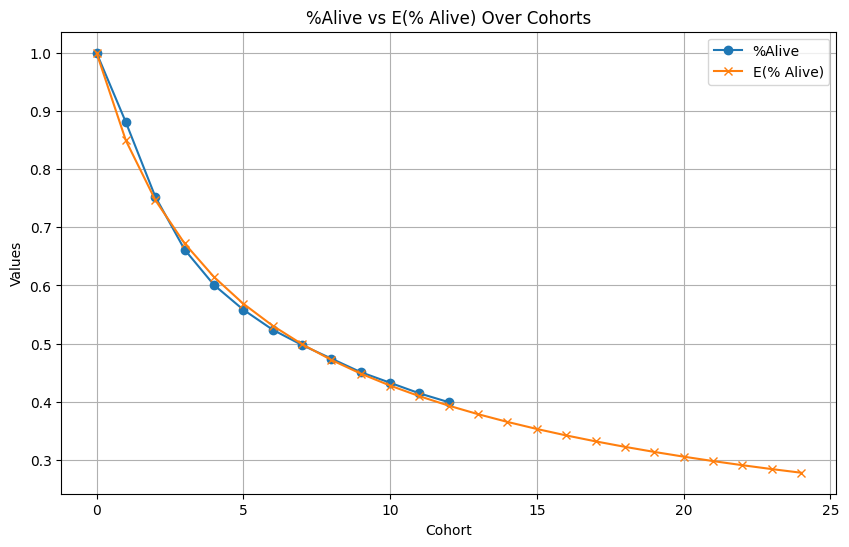

In [15]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.special import gammaln

# 1. Load the CSV file
file_path = "/content/rich_sample_data.csv"  # Replace with your CSV file path
df = pd.read_csv(file_path)

# Assuming there is a date column in your CSV named 'date'
# 2. Add a column with month names and sort
df['month'] = pd.to_datetime(df['date']).dt.strftime('%b')
df['date'] = pd.to_datetime(df['date'])
df['birthday'] = pd.to_datetime(df['birthday'])

# 2.5 (New Step): Filter DataFrame for customers with birthday '1/1/2018'
birthday_filter = pd.Timestamp('2018-01-01')
df_filtered = df[df['birthday'] == birthday_filter]
df_filtered = df_filtered.sort_values(by='date')

# 3. Group by month and count distinct cust_id
grouped_df = df_filtered.groupby('date').agg({'cust_id': pd.Series.nunique}).reset_index()
grouped_df = grouped_df.rename(columns={'cust_id': 'distinct_cust_count'})

# Sort the grouped DataFrame by date
grouped_df['date'] = pd.to_datetime(grouped_df['date'])
grouped_df = grouped_df.sort_values(by='date')

# 4. Add a new index column connected with month
grouped_df['cohort'] = range(len(grouped_df))
grouped_df

# 5. Calculate '%Alive' column
base_value = grouped_df.loc[grouped_df['cohort'] == 0, 'distinct_cust_count'].iloc[0]
grouped_df['%Alive'] = grouped_df['distinct_cust_count'] / base_value
df = grouped_df

# 6.Define the E(% Alive) function
def e_alive(cohort, gamma, delta):
    return np.exp(gammaln(delta + cohort) + gammaln(gamma + delta) - gammaln(delta) - gammaln(gamma + delta + cohort))

# Define the P(ChurnTime = t) and E(# of Cust) functions
def calculate_values(df, gamma, delta):
    df['E(% Alive)'] = e_alive(df['cohort'], gamma, delta)
    df['P(ChurnTime = t)'] = df['E(% Alive)'].diff().fillna(df['E(% Alive)'].iloc[0])
    df['E(# of Cust)'] = df['distinct_cust_count'].iloc[0] * df['E(% Alive)']
    return df

# Define the SSE function
def sse(params):
    gamma, delta = params
    df_temp = calculate_values(df.copy(), gamma, delta)
    return np.sum((df_temp['E(# of Cust)'] - df_temp['distinct_cust_count']) ** 2)

# Initial guess for gamma and delta
initial_guess = [1, 1]

# Perform the minimization, ensuring gamma and delta are greater than 0
result = minimize(sse, initial_guess, bounds=[(0.00001, None), (0.00001, None)])

# Extract the optimized gamma and delta values
optimized_gamma, optimized_delta = result.x

# print(f"Optimized Gamma: {optimized_gamma}, Optimized Delta: {optimized_delta}")

df = calculate_values(df, optimized_gamma, optimized_delta)

# Extend the cohort values up to 24
max_cohort = df['cohort'].max()
for cohort in range(max_cohort + 1, 25):
    df = df.append({'cohort': cohort, '%Alive': np.nan}, ignore_index=True)

# Calculate E(% Alive) for the entire range of cohorts
df['E(% Alive)'] = e_alive(df['cohort'], optimized_gamma, optimized_delta)

# Calculate P(ChurnTime = t) and E(# of Cust)
initial_cust_count = df['distinct_cust_count'].iloc[0]
df['P(ChurnTime = t)'] = df['E(% Alive)'].diff().fillna(df['E(% Alive)'].iloc[0])
df['E(# of Cust)'] = initial_cust_count * df['E(% Alive)']

from pandas.tseries.offsets import MonthEnd, MonthBegin
start_month = df['date'].min()
df['cohort_month'] = df.apply(lambda row: start_month + MonthBegin(n=int(row['cohort'])), axis=1)
df_final = df[['cohort_month', 'cohort', 'distinct_cust_count', '%Alive', 'E(% Alive)', 'P(ChurnTime = t)', 'E(# of Cust)']]
df_final
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['cohort'], df['%Alive'], label='%Alive', marker='o')
plt.plot(df['cohort'], df['E(% Alive)'], label='E(% Alive)', marker='x')
plt.xlabel('Cohort')
plt.ylabel('Values')
plt.title('%Alive vs E(% Alive) Over Cohorts')
plt.legend()
plt.grid(True)
plt.show()



In [6]:
# 1. Load the CSV file
file_path = "/content/rich_sample_data.csv"  # Replace with your CSV file path
df = pd.read_csv(file_path)

In [7]:
# Assuming there is a date column in your CSV named 'date'
# 2. Add a column with month names and sort
df['month'] = pd.to_datetime(df['date']).dt.strftime('%b')
df['date'] = pd.to_datetime(df['date'])
df['birthday'] = pd.to_datetime(df['birthday'])

# 2.5 (New Step): Filter DataFrame for customers with birthday '1/1/2018'
birthday_filter = pd.Timestamp('2018-01-01')
df_filtered = df[df['birthday'] == birthday_filter]
df_filtered = df_filtered.sort_values(by='date')

In [8]:
# 3. Group by month and count distinct cust_id
grouped_df = df_filtered.groupby('date').agg({'cust_id': pd.Series.nunique}).reset_index()
grouped_df = grouped_df.rename(columns={'cust_id': 'distinct_cust_count'})

# Sort the grouped DataFrame by date
grouped_df['date'] = pd.to_datetime(grouped_df['date'])
grouped_df = grouped_df.sort_values(by='date')

In [9]:
# 4. Add a new index column connected with month
grouped_df['cohort'] = range(len(grouped_df))

In [10]:
# 5. Calculate '%Alive' column
base_value = grouped_df.loc[grouped_df['cohort'] == 0, 'distinct_cust_count'].iloc[0]
grouped_df['%Alive'] = grouped_df['distinct_cust_count'] / base_value

In [120]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.special import gammaln

In [121]:
# Define the E(% Alive) function
def e_alive(cohort, gamma, delta):
    return np.exp(gammaln(delta + cohort) + gammaln(gamma + delta) - gammaln(delta) - gammaln(gamma + delta + cohort))

# Define the P(ChurnTime = t) and E(# of Cust) functions
def calculate_values(df, gamma, delta):
    df['E(% Alive)'] = e_alive(df['cohort'], gamma, delta)
    df['P(ChurnTime = t)'] = df['E(% Alive)'].diff().fillna(df['E(% Alive)'].iloc[0])
    df['E(# of Cust)'] = df['distinct_cust_count'].iloc[0] * df['E(% Alive)']
    return df

# Define the SSE function
def sse(params):
    gamma, delta = params
    df_temp = calculate_values(df.copy(), gamma, delta)
    return np.sum((df_temp['E(# of Cust)'] - df_temp['distinct_cust_count']) ** 2)

In [122]:

# Initial guess for gamma and delta
initial_guess = [1, 1]

# Perform the minimization, ensuring gamma and delta are greater than 0
result = minimize(sse, initial_guess, bounds=[(0.00001, None), (0.00001, None)])

KeyError: ignored

In [74]:
# Extract the optimized gamma and delta values
optimized_gamma, optimized_delta = result.x

print(f"Optimized Gamma: {optimized_gamma}, Optimized Delta: {optimized_delta}")

Optimized Gamma: 0.594556548470135, Optimized Delta: 3.345422615709572


In [75]:
# Apply the optimized gamma and delta values to the DataFrame
df = calculate_values(df, optimized_gamma, optimized_delta)
df
df_bkp = df

In [76]:
#df = df_bkp
df

,date,distinct_cust_count,cohort,%Alive,E(% Alive),P(ChurnTime = t),E(# of Cust)
0,2018-01-01,987,0,1.000000,1.000000,1.000000,987.000000
1,2018-02-01,869,1,0.880446,0.849097,-0.150903,838.058270
2,2018-03-01,743,2,0.752786,0.746903,-0.102194,737.192858
3,2018-04-01,653,3,0.661601,0.672142,-0.074761,663.404242
4,2018-05-01,593,4,0.600811,0.614559,-0.057583,606.569585
5,2018-06-01,551,5,0.558257,0.568540,-0.046019,561.148821
6,2018-07-01,517,6,0.523810,0.530729,-0.037811,523.829416
7,2018-08-01,491,7,0.497467,0.498984,-0.031745,492.496733
8,2018-09-01,468,8,0.474164,0.471865,-0.027118,465.730946
9,2018-10-01,445,9,0.450861,0.448368,-0.023497,442.539667


In [ ]:
# Extend the cohort values up to 24
max_cohort = df['cohort'].max()
for cohort in range(max_cohort + 1, 25):
    df = df.append({'cohort': cohort, '%Alive': np.nan}, ignore_index=True)


# Calculate E(% Alive) for the entire range of cohorts
df['E(% Alive)'] = e_alive(df['cohort'], optimized_gamma, optimized_delta)


In [78]:
# Calculate P(ChurnTime = t) and E(# of Cust)
initial_cust_count = df['distinct_cust_count'].iloc[0]
df['P(ChurnTime = t)'] = df['E(% Alive)'].diff().fillna(df['E(% Alive)'].iloc[0])
df['E(# of Cust)'] = initial_cust_count * df['E(% Alive)']
df

In [83]:
from pandas.tseries.offsets import MonthEnd, MonthBegin
start_month = df['date'].min()
df['cohort_month'] = df.apply(lambda row: start_month + MonthBegin(n=int(row['cohort'])), axis=1)
df_final = df[['cohort_month', 'cohort', 'distinct_cust_count', '%Alive', 'E(% Alive)', 'P(ChurnTime = t)', 'E(# of Cust)']]
df_final


In [91]:
import matplotlib.pyplot as plt

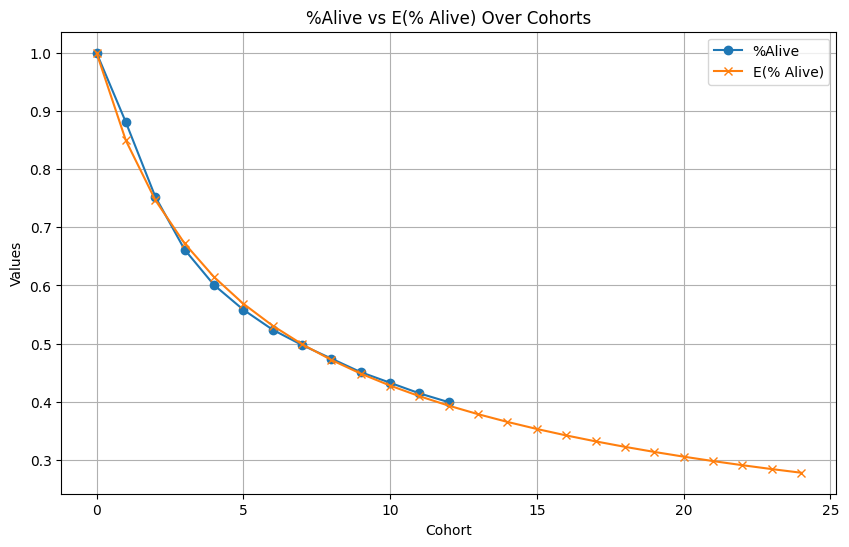

In [92]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['cohort'], df['%Alive'], label='%Alive', marker='o')
plt.plot(df['cohort'], df['E(% Alive)'], label='E(% Alive)', marker='x')
plt.xlabel('Cohort')
plt.ylabel('Values')
plt.title('%Alive vs E(% Alive) Over Cohorts')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.special import gammaln

# Function Definitions
def load_and_preprocess_data(file_path):
    """
    Loads the CSV data, preprocesses it by adding month, date, and birthday columns,
    and filters data for customers with a specific birthday.
    """
    df = pd.read_csv(file_path)
    df['month'] = pd.to_datetime(df['date']).dt.strftime('%b')
    df['date'] = pd.to_datetime(df['date'])
    df['birthday'] = pd.to_datetime(df['birthday'])

    # Filter DataFrame for customers with birthday '1/1/2018'
    birthday_filter = pd.Timestamp('2018-01-01')
    df_filtered = df[df['birthday'] == birthday_filter]
    df_filtered.sort_values(by='date', inplace=True)
    return df_filtered

def calculate_distinct_customer_count(df):
    """
    Groups data by date and counts distinct customer IDs.
    """
    grouped_df = df.groupby('date').agg({'cust_id': pd.Series.nunique}).reset_index()
    grouped_df = grouped_df.rename(columns={'cust_id': 'distinct_cust_count'})
    grouped_df['date'] = pd.to_datetime(grouped_df['date'])
    grouped_df.sort_values(by='date', inplace=True)
    return grouped_df

def calculate_alive_percentage(df):
    """
    Calculates '%Alive' column for the DataFrame.
    """
    base_value = df.loc[df['cohort'] == 0, 'distinct_cust_count'].iloc[0]
    df['%Alive'] = df['distinct_cust_count'] / base_value
    return df

def e_alive(cohort, gamma, delta):
    """
    E(% Alive) function.
    """
    return np.exp(gammaln(delta + cohort) + gammaln(gamma + delta) - gammaln(delta) - gammaln(gamma + delta + cohort))

def calculate_values(df, gamma, delta):
    """
    Calculates E(% Alive), P(ChurnTime = t), and E(# of Cust) for the DataFrame.
    """
    df['E(% Alive)'] = e_alive(df['cohort'], gamma, delta)
    df['P(ChurnTime = t)'] = df['E(% Alive)'].diff().fillna(df['E(% Alive)'].iloc[0])
    df['E(# of Cust)'] = df['distinct_cust_count'].iloc[0] * df['E(% Alive)']
    return df

def sse(params, df):
    """
    SSE function for optimization.
    """
    gamma, delta = params
    df_temp = calculate_values(df.copy(), gamma, delta)
    return np.sum((df_temp['E(# of Cust)'] - df_temp['distinct_cust_count']) ** 2)

def optimize_gamma_delta(df, initial_guess):
    """
    Optimizes gamma and delta values using the SSE function.
    """
    result = minimize(sse, initial_guess, args=(df,), bounds=[(0.00001, None), (0.00001, None)])
    return result.x


In [20]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.special import gammaln

# Function Definitions
def load_and_preprocess_data(file_path):
    """
    Loads the CSV data, preprocesses it by adding month, date, and birthday columns,
    and filters data for customers with a specific birthday.
    """
    df = pd.read_csv(file_path)
    df['month'] = pd.to_datetime(df['date']).dt.strftime('%b')
    df['date'] = pd.to_datetime(df['date'])
    df['birthday'] = pd.to_datetime(df['birthday'])

    # Filter DataFrame for customers with birthday '1/1/2018'
    birthday_filter = pd.Timestamp('2018-01-01')
    df_filtered = df[df['birthday'] == birthday_filter]
    df_filtered.sort_values(by='date', inplace=True)
    return df_filtered

def calculate_distinct_customer_count(df):
    """
    Groups data by date and counts distinct customer IDs.
    """
    grouped_df = df.groupby('date').agg({'cust_id': pd.Series.nunique}).reset_index()
    grouped_df = grouped_df.rename(columns={'cust_id': 'distinct_cust_count'})
    grouped_df['date'] = pd.to_datetime(grouped_df['date'])
    grouped_df.sort_values(by='date', inplace=True)
    return grouped_df

def calculate_alive_percentage(df):
    """
    Calculates '%Alive' column for the DataFrame.
    """
    base_value = df.loc[df['cohort'] == 0, 'distinct_cust_count'].iloc[0]
    df['%Alive'] = df['distinct_cust_count'] / base_value
    return df

def e_alive(cohort, gamma, delta):
    """
    E(% Alive) function.
    """
    return np.exp(gammaln(delta + cohort) + gammaln(gamma + delta) - gammaln(delta) - gammaln(gamma + delta + cohort))

def calculate_values(df, gamma, delta):
    """
    Calculates E(% Alive), P(ChurnTime = t), and E(# of Cust) for the DataFrame.
    """
    df['E(% Alive)'] = e_alive(df['cohort'], gamma, delta)
    df['P(ChurnTime = t)'] = df['E(% Alive)'].diff().fillna(df['E(% Alive)'].iloc[0])
    df['E(# of Cust)'] = df['distinct_cust_count'].iloc[0] * df['E(% Alive)']
    return df

def sse(params, df):
    """
    SSE function for optimization.
    """
    gamma, delta = params
    df_temp = calculate_values(df.copy(), gamma, delta)
    return np.sum((df_temp['E(# of Cust)'] - df_temp['distinct_cust_count']) ** 2)

def optimize_gamma_delta(df, initial_guess):
    """
    Optimizes gamma and delta values using the SSE function.
    """
    result = minimize(sse, initial_guess, args=(df,), bounds=[(0.00001, None), (0.00001, None)])
    return result.x

# Main Script
file_path = "/content/rich_sample_data.csv"  # Replace with your CSV file path
try:
    df_filtered = load_and_preprocess_data(file_path)
except FileNotFoundError:
    print("File not found. Please check the file path and try again.")
    exit()

grouped_df = calculate_distinct_customer_count(df_filtered)
grouped_df['cohort'] = range(len(grouped_df))
grouped_df = calculate_alive_percentage(grouped_df)

# Optimization
initial_guess = [1, 1]
optimized_gamma, optimized_delta = optimize_gamma_delta(grouped_df, initial_guess)

grouped_df = calculate_values(grouped_df, optimized_gamma, optimized_delta)

# Extend the cohort values up to 24 using vectorized operations
max_cohort = grouped_df['cohort'].max()
extended_cohorts = pd.DataFrame({'cohort': range(max_cohort + 1, 25), '%Alive': np.nan})
grouped_df = pd.concat([grouped_df, extended_cohorts], ignore_index=True)

# Calculate E(% Alive) for the entire range of cohorts
grouped_df['E(% Alive)'] = e_alive(grouped_df['cohort'], optimized_gamma, optimized_delta)

# Calculate P(ChurnTime = t) and E(# of Cust)
initial_cust_count = grouped_df['distinct_cust_count'].iloc[0]
grouped_df['P(ChurnTime = t)'] = grouped_df['E(% Alive)'].diff().fillna(grouped_df['E(% Alive)'].iloc[0])
grouped_df['E(# of Cust)'] = initial_cust_count * grouped_df['E(% Alive)']

# Adding cohort month
from pandas.tseries.offsets import MonthBegin
start_month = grouped_df['date'].min()
grouped_df['cohort_month'] = grouped_df.apply(lambda row: start_month + MonthBegin(n=int(row['cohort'])), axis=1)

# Final DataFrame
df_final = grouped_df[['cohort_month', 'cohort', 'distinct_cust_count', '%Alive', 'E(% Alive)', 'P(ChurnTime = t)', 'E(# of Cust)']]
df_final


<ipython-input-20-07dc42d3dcfe>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.sort_values(by='date', inplace=True)


,cohort_month,cohort,distinct_cust_count,%Alive,E(% Alive),P(ChurnTime = t),E(# of Cust)
0,2018-01-01,0,987.0,1.000000,1.000000,1.000000,987.000000
1,2018-02-01,1,869.0,0.880446,0.849097,-0.150903,838.058270
2,2018-03-01,2,743.0,0.752786,0.746903,-0.102194,737.192858
3,2018-04-01,3,653.0,0.661601,0.672142,-0.074761,663.404242
4,2018-05-01,4,593.0,0.600811,0.614559,-0.057583,606.569585
5,2018-06-01,5,551.0,0.558257,0.568540,-0.046019,561.148821
6,2018-07-01,6,517.0,0.523810,0.530729,-0.037811,523.829416
7,2018-08-01,7,491.0,0.497467,0.498984,-0.031745,492.496733
8,2018-09-01,8,468.0,0.474164,0.471865,-0.027118,465.730946
9,2018-10-01,9,445.0,0.450861,0.448368,-0.023497,442.539667
